# Qiskit Runtime Primitives Track

# Part 2: Applied Example


**Task:** To set up ibmq_qasm_simulator and map a basic noise model for an IBM Quantum hardware device in Qiskit Runtime, and use this noise model to perform noisy simulations of `QuantumCircuits` using `Sampler` and `Estimator` to study the effects of errors which occur on real devices.

# Step 1: Set up environment

In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService
from tokens import IQP_TOKEN

# save account
QiskitRuntimeService.save_account(channel="ibm_quantum", token=IQP_TOKEN, overwrite=True)

# start service
service = QiskitRuntimeService(channel="ibm_quantum")

# Step 2: Define target circuit

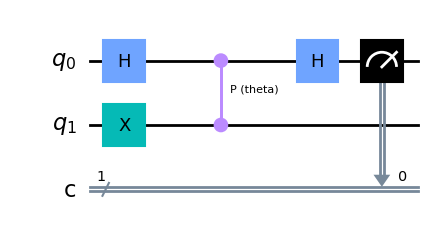

In [2]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

theta = Parameter('theta')

qc = QuantumCircuit(2,1)
qc.x(1)
qc.h(0)
qc.cp(theta,0,1)
qc.h(0)
qc.measure(0,0)

qc.draw('mpl')

The circuit shown by the previous cell is parameterized with the eigenvalue being kicked back into qubit 0 to be measured. The amount of kickback will be determined by the parameter theta. Now in the following cell, we shall define our parameters for our circuit as a list. The parameters here will be from to divided over 50 evenly spaced points.

In [3]:
import numpy as np

phases = np.linspace(0, 2*np.pi, 50)

# phases need to be expressed as a list of lists in order to work
individual_phases = [[phase] for phase in phases]

# Step 3: Select backend and set up primitive options

First, let's define "ibmq-qasm-simulator" as our target backend

In [4]:
backend = "ibmq_qasm_simulator"

The `ibmq-qasm-simulator` can mimic real backends if provided with the following information: the device's **noise model**, **basis gates** and **coupling map**. In this example, we will extract such information from a fake backend, and then passed on to the simulator through the primitive options

In [5]:
from qiskit.providers.fake_provider import FakeManila
from qiskit_aer.noise import NoiseModel

# Instantiate fake backend
fake_backend = FakeManila()

# Extract noise model
noise_model = NoiseModel.from_backend(fake_backend)

# Extract basis gates
basis_gates = fake_backend.configuration().basis_gates

# Extract coupling map
coupling_map = fake_backend.configuration().coupling_map

In this example we will compare the execution with an without error mitigations. For this means, we will define two different set of options.

First, let's define the following options for the non-mitigated execution:

- number of shots: 1000
- optimization level = 0
- error mitigation level = 0
- simulator options:
    - simulator seed = 42
    - noise model = `noise_model`
    - basis gates = `basis_gates`
    - coupling map = `coupling_map`

In [6]:
from qiskit_ibm_runtime import Options

options_without_em = Options()
options_without_em.execution.shots = 1000
options_without_em.optimization_level = 0
options_without_em.resilience_level = 0
options_without_em.simulator.seed_simulator = 42
options_without_em.simulator.noise_model = noise_model
options_without_em.simulator.basis_gates = basis_gates
options_without_em.simulator.coupling_map = coupling_map

Now, let's modify the error mitigation level to 1, and define a new set of options:

- number of shots: 1000
- optimization level = 0
- error mitigation level = 1
- simulator options:
    - simulator seed = 42
    - noise model = `noise_model`
    - basis gates = `basis_gates`
    - coupling map = `coupling_map`

In [7]:
options_with_em = Options()
options_with_em.execution.shots = 1000
options_with_em.optimization_level = 0
options_with_em.resilience_level = 1
options_with_em.simulator.seed_simulator = 42
options_with_em.simulator.noise_model = noise_model
options_with_em.simulator.basis_gates = basis_gates
options_with_em.simulator.coupling_map = coupling_map

# Step 4: Launch!

Now, let's open a runtime session, and within that session, define two `Sampler` instances, each using one of the option instances defined above. 

In [9]:
from qiskit_ibm_runtime import Sampler, Session

# insert here session syntax
with Session(service=service, backend=backend) as session:
    
    sampler_1 = Sampler(options=options_without_em)
    job_1 = sampler_1.run(circuits = [qc] * len(individual_phases), parameter_values = individual_phases)
    result_1 = job_1.result()
    prob_values_1 = [1-dist[0] for dist in result_1.quasi_dists]

    sampler_2 = Sampler(options=options_with_em)
    job_2 = sampler_2.run(circuits = [qc] * len(individual_phases), parameter_values = individual_phases)
    result_2 = job_2.result()
    prob_values_2 = [1-dist[0] for dist in result_2.quasi_dists]


Finally, let's plot and see our results:

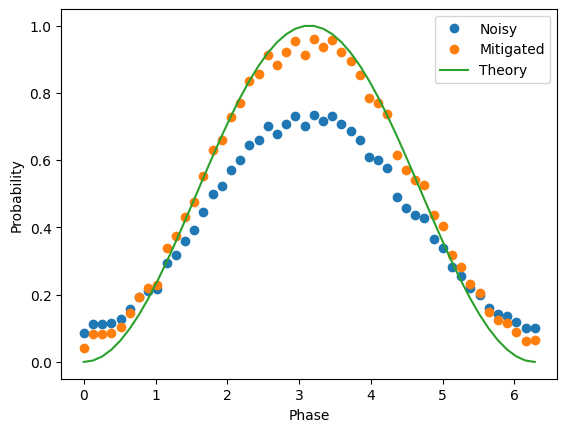

In [11]:
import matplotlib.pyplot as plt

plt.plot(phases, prob_values_1, 'o', label='Noisy')
plt.plot(phases, prob_values_2, 'o', label='Mitigated')
plt.plot(phases, np.sin(phases/2,)**2, label='Theory')
plt.xlabel('Phase')
plt.ylabel('Probability')
plt.legend()